In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(196)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.4:41588 Dashboard: http://172.30.100.4:40809/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8146047     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8146048     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8146049     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8146050     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8146051     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8146052     hsw24 make_pro albert7a PD       0:00      1 (Priority)
           8146053     hsw24 make_pro albert7a PD       0:00      1 (Priority)


In [4]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

51


In [5]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [6]:
#params

plot_eke_monthly=False
plot_eke_12_month=True
plot_eke_annual=False


In [7]:
config='EU36'
case='MPC001'
freq='1d'
year='2011'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

In [8]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [9]:
def compute_EKE(u2,v2,u2mean,v2mean):
    ua=0.5*((-1*u2+u2mean)+(-1*u2.shift(x=1)+u2mean.shift(x=1)))
    va=0.5*((-1*v2+v2mean)+(-1*v2.shift(y=1)+v2mean.shift(y=1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [10]:
dsU=xr.open_mfdataset('/scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2011/EU36-MPC001_y2011m??d??.1d_gridU.nc', chunks={'x':700,'y':1000,'time_counter':10,'depthu':1})
dsV=xr.open_mfdataset('/scratch/cnt0024/hmg2840/colombo/EU36/EU36-MPC001-S/1d/2011/EU36-MPC001_y2011m??d??.1d_gridV.nc', chunks={'x':700,'y':1000,'time_counter':10,'depthv':1})
u=dsU.vozocrtx
v=dsV.vomecrty
mask=dsmask.tmask[0]
u2=u*u
v2=v*v
u2mean=u2.mean(dim='time_counter')
v2mean=v2.mean(dim='time_counter')


In [11]:
umonth=u.groupby('time_counter.month').mean('time_counter')
vmonth=v.groupby('time_counter.month').mean('time_counter')


In [12]:
umonth2=umonth*umonth
vmonth2=vmonth*vmonth


In [13]:
umonth2mean=umonth2.mean(dim='month')
vmonth2mean=vmonth2.mean(dim='month')

In [14]:
eke=compute_EKE(umonth2,vmonth2,umonth2mean,vmonth2mean)

In [15]:
eke

<xarray.DataArray (month: 12, deptht: 75, y: 1718, x: 732)>
dask.array<shape=(12, 75, 1718, 732), dtype=float32, chunksize=(1, 1, 1000, 700)>
Coordinates:
  * deptht   (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: y, x

In [16]:
month_name={1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
def plot_one_month(var,vmin,vmax,cmap,title,figfile,month,year):
    fig, ax = plt.subplots(1,1,figsize=(10,15))
    var.plot(cmap=cmap,ax=ax,vmin=vmin,vmax=vmax,add_labels=True)
    ax.set_title(month_name[month])
    fig.suptitle('Monthly mean of '+str(title))
    plt.savefig('Plots/EU36/Maps/'+config+'-'+case+'y'+str(year)+'m'+str(month)+'_'+figfile+'.png')

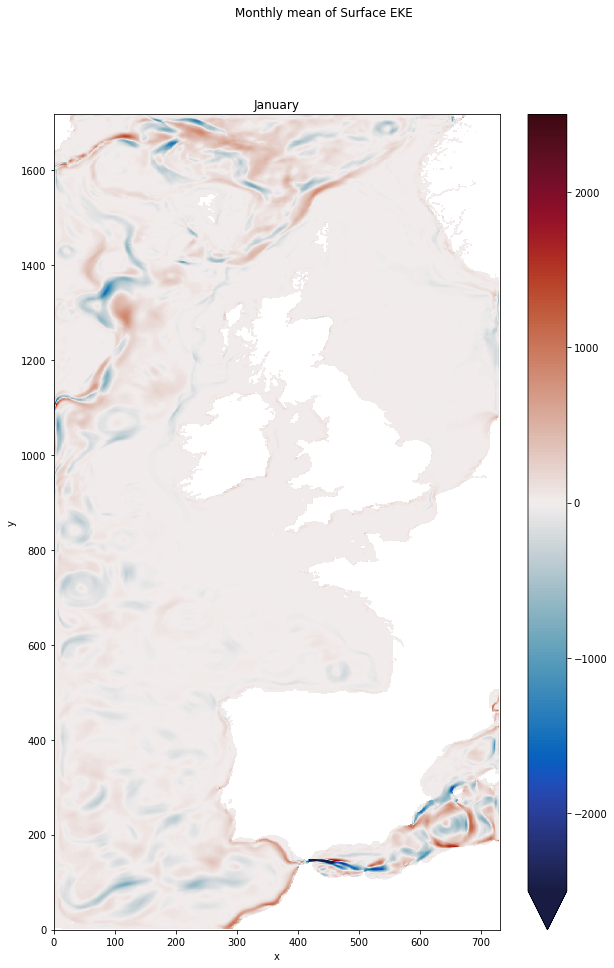

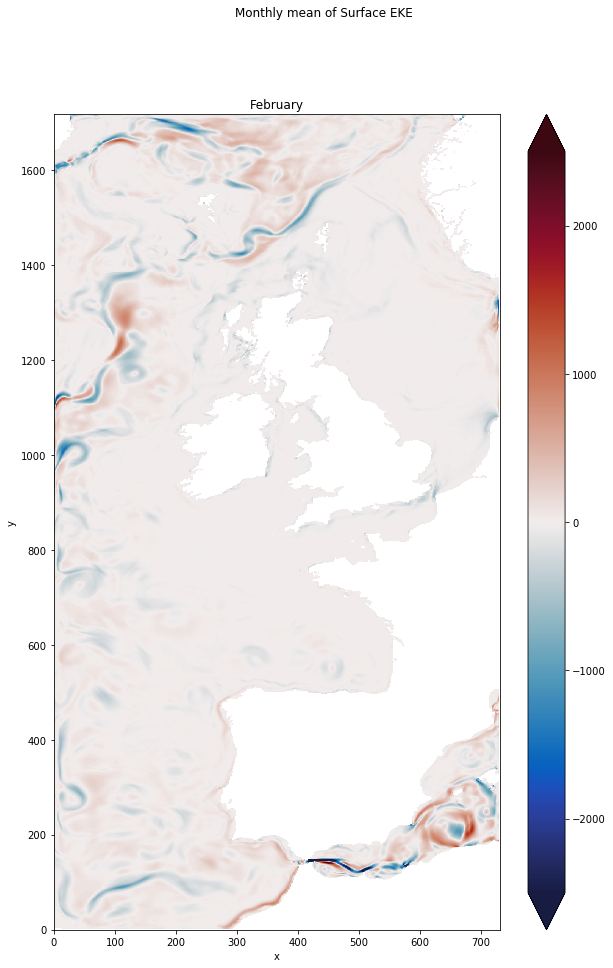

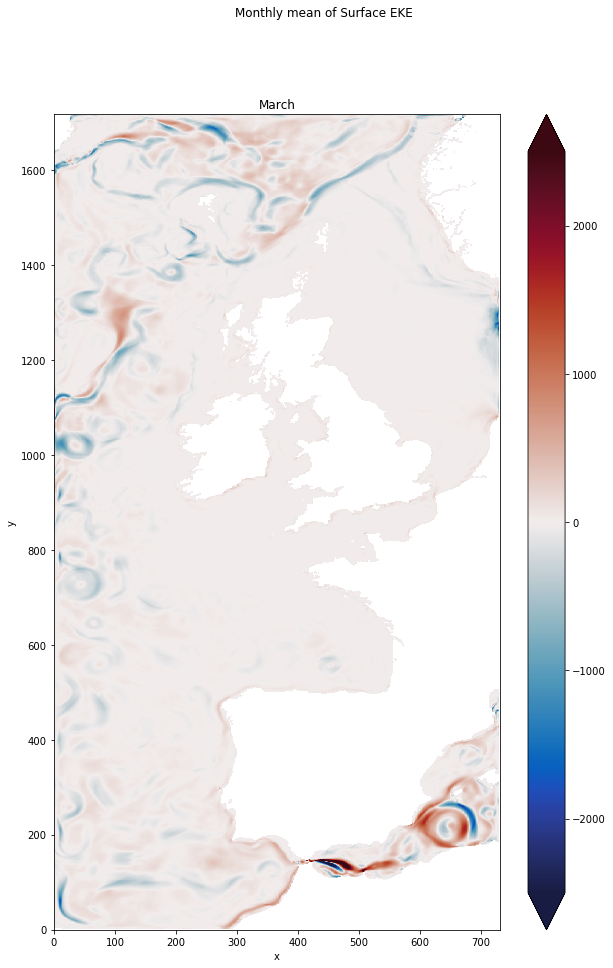

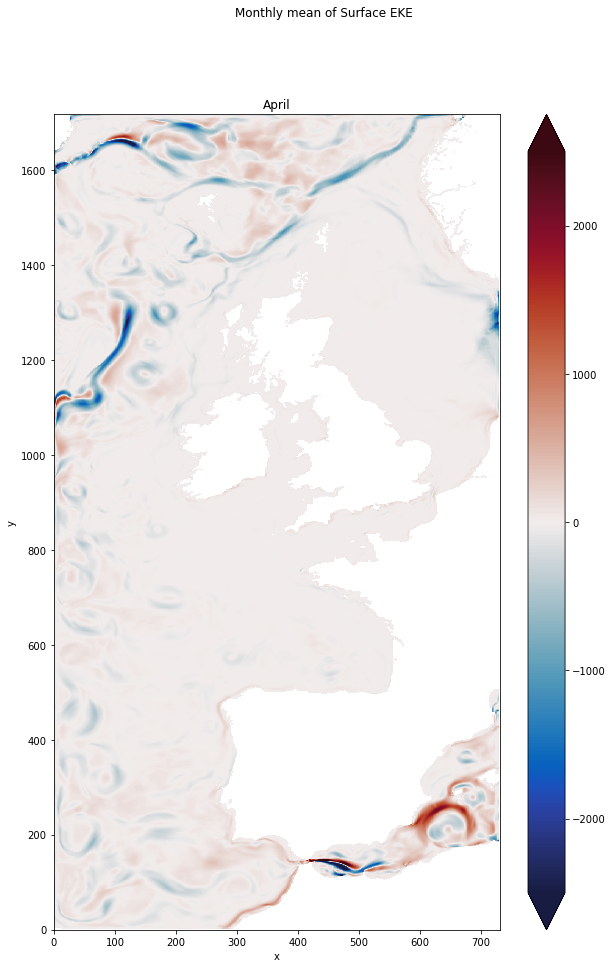

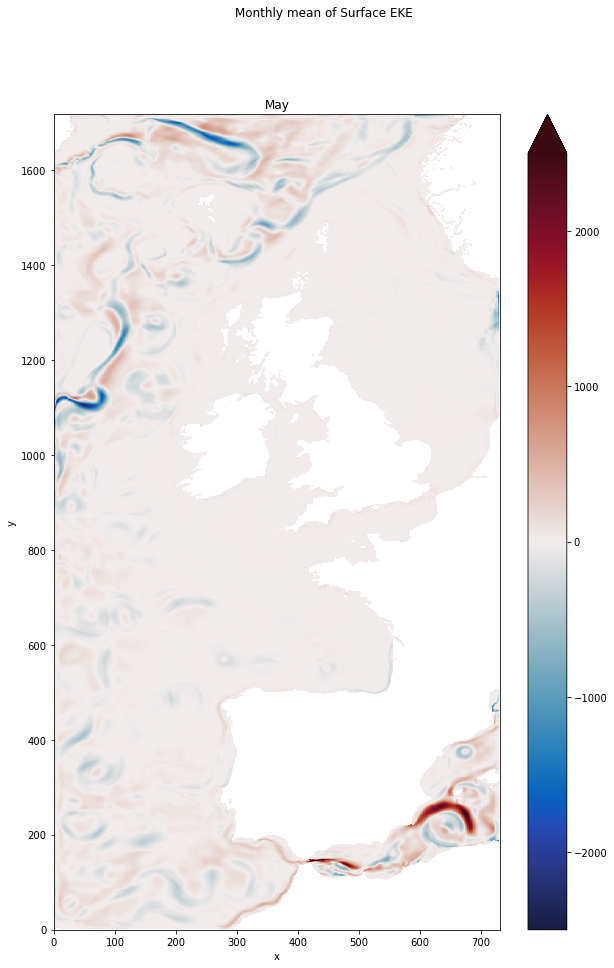

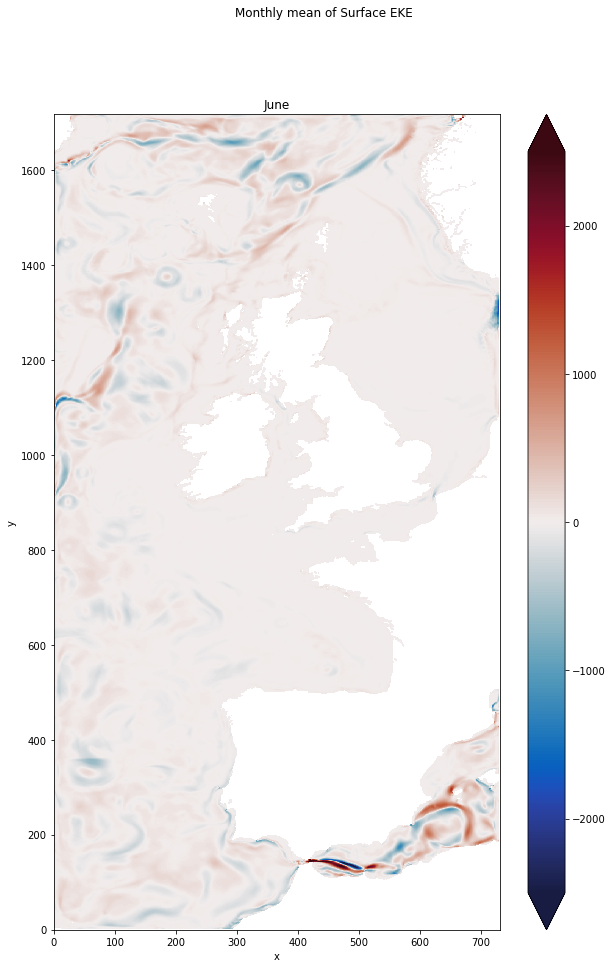

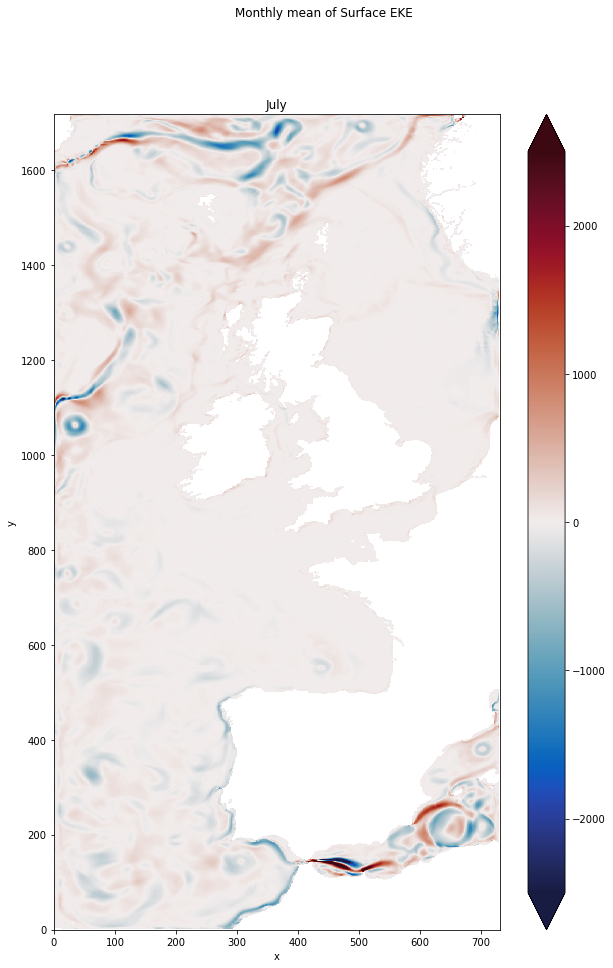

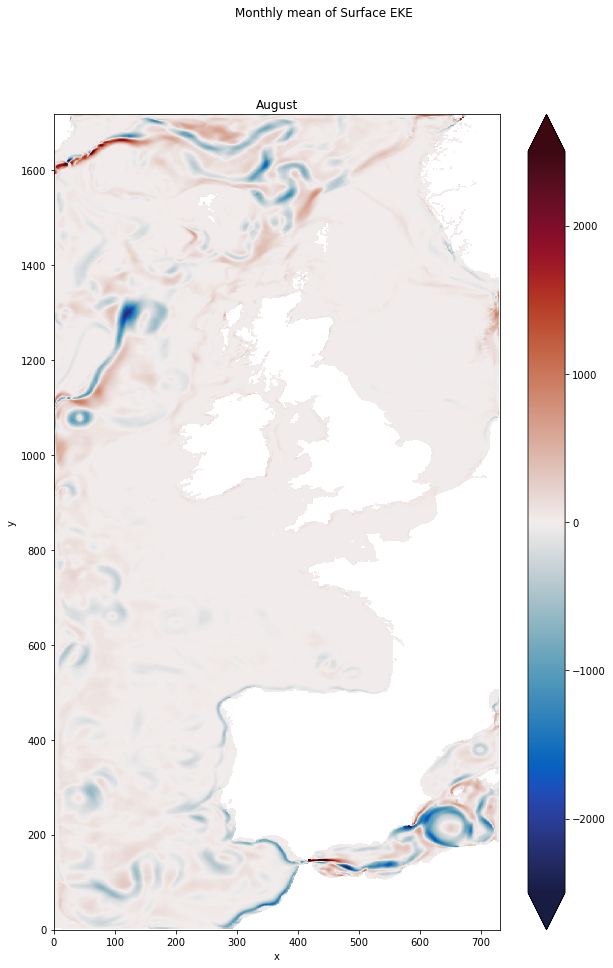

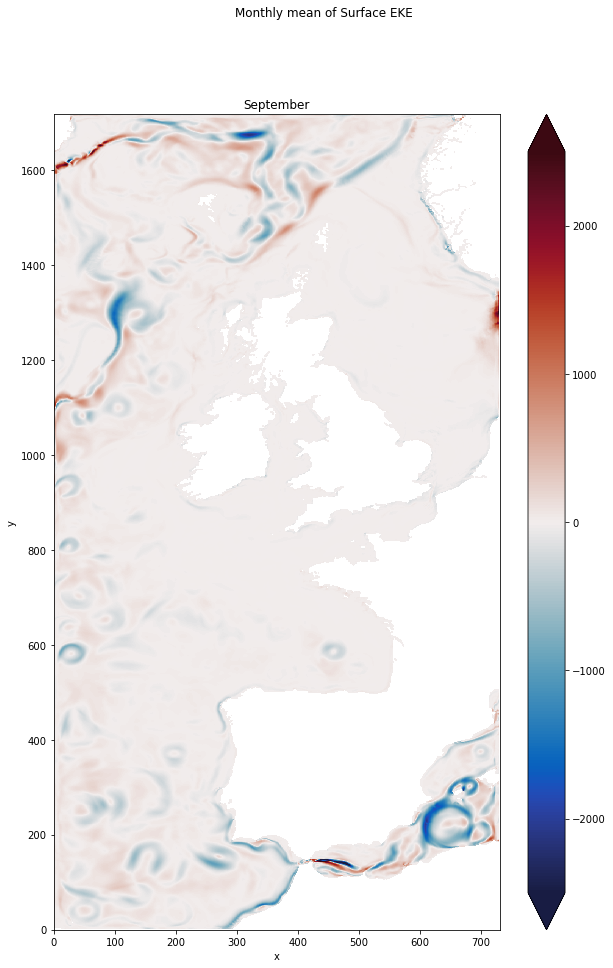

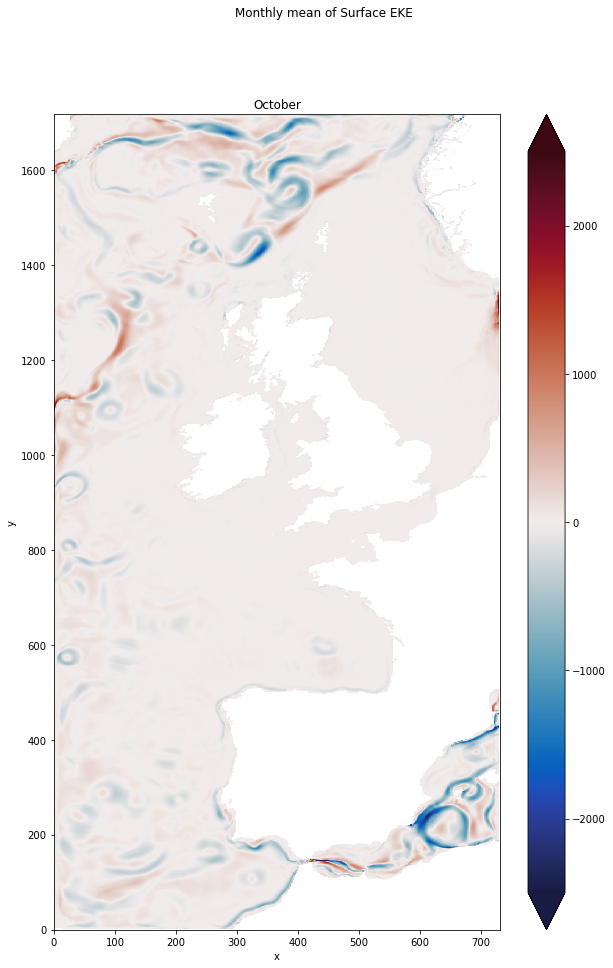

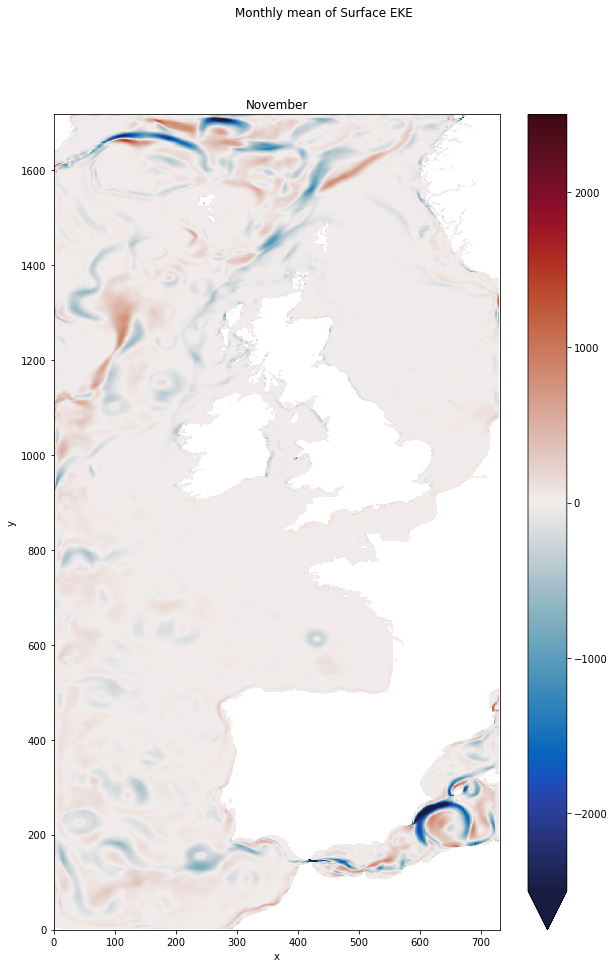

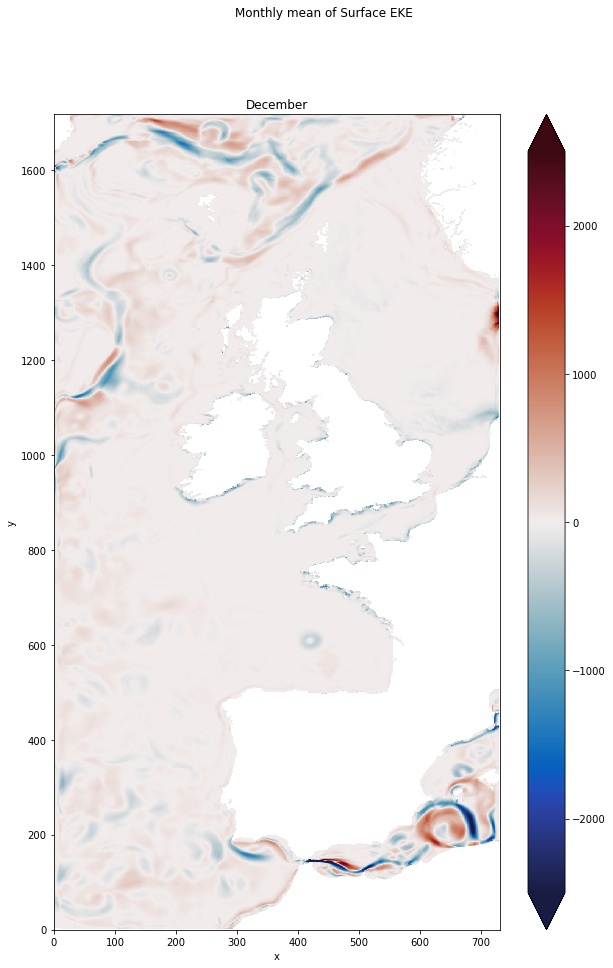

In [17]:
for m in np.arange(1,13):
    plot_one_month(10000*eke[m-1,0],-2500,2500,'cmo.balance','Surface EKE','eke_surf',m,2011)
   